# SD201 project

- Create dataset from scraping with steam api
- Make apriori algorithm on bought games
- Make knn algorithm on hours played
- Use steam api to make recommendations to a player

# Formulate the question

Knowing the games someone bought and how many hours they played it on Steam, what are the other games they could like and thus potentially buy ?

# Finding the dataset

We'll first test the algorithms on an already existing dataset, and we will then try to create our own dataset with Steam's api.

We choose this dataset : https://www.kaggle.com/datasets/tamber/steam-video-games.  
Indeed, it gives us a huge amount of users with their bought and played games on Steam, which will enable us to predict what kind of games they like (supposing that the more someone plays a game, the more he likes it), 

In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('steam-200k.csv')

In [4]:
df.head()

,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
0,151603712,The Elder Scrolls V Skyrim,play,273.0,0
1,151603712,Fallout 4,purchase,1.0,0
2,151603712,Fallout 4,play,87.0,0
3,151603712,Spore,purchase,1.0,0
4,151603712,Spore,play,14.9,0


In [5]:
df.describe()

,151603712,1.0,0
count,1.999990e+05,199999.000000,199999.0
mean,1.036556e+08,17.874468,0.0
std,7.208084e+07,138.057292,0.0
min,5.250000e+03,0.100000,0.0
25%,4.738420e+07,1.000000,0.0
50%,8.691201e+07,1.000000,0.0
75%,1.542309e+08,1.300000,0.0
max,3.099031e+08,11754.000000,0.0


The dataset cumulates 2 000 000 hours played, which seems enough, and we will check the number of users when the data will be a little bit cleaner.

# Cleaning the data

## Renaming the columns

In [6]:
df.columns = ['id','game','state','hours_played','0']
df.head()

,id,game,state,hours_played,0
0,151603712,The Elder Scrolls V Skyrim,play,273.0,0
1,151603712,Fallout 4,purchase,1.0,0
2,151603712,Fallout 4,play,87.0,0
3,151603712,Spore,purchase,1.0,0
4,151603712,Spore,play,14.9,0


In [7]:
df['id'].nunique()

12393

We have 12393 users in the dataset, which seems to be a good start to create recommendations.

## Removing the column always equals to 0

In [8]:
df = df.drop('0',axis=1)
df.head()

,id,game,state,hours_played
0,151603712,The Elder Scrolls V Skyrim,play,273.0
1,151603712,Fallout 4,purchase,1.0
2,151603712,Fallout 4,play,87.0
3,151603712,Spore,purchase,1.0
4,151603712,Spore,play,14.9


## Look out for NaN values

In [9]:
df.isnull().values.any()

False

There are no NaN values in the dataset

## Separate games bought and games played

In [10]:
bought_games = df.loc[df['state']=='purchase']
played_games = df.loc[df['state']=='play']

For the bought_games, the hours_played has been set to 1 but it is irrelevant, so we can drop the column

In [11]:
bought_games = bought_games.drop(['hours_played','state'],axis=1)
bought_games.head()

,id,game
1,151603712,Fallout 4
3,151603712,Spore
5,151603712,Fallout New Vegas
7,151603712,Left 4 Dead 2
9,151603712,HuniePop


In [12]:
played_games = played_games.drop(['state'],axis=1)
played_games.head()

,id,game,hours_played
0,151603712,The Elder Scrolls V Skyrim,273.0
2,151603712,Fallout 4,87.0
4,151603712,Spore,14.9
6,151603712,Fallout New Vegas,12.1
8,151603712,Left 4 Dead 2,8.9


## Standardizing the data

We standardize the hours played so that games with higher average time played will not mess with the predictions. To do so, we use the means and stds of each game to standardize them.   
In particular, we will standardize the data not to be too much affected by outliers.  


In [13]:
standardization_dict = dict()
for game_name, s in played_games.groupby('game')['hours_played']:
    standardization_dict[game_name]=dict()
    series = s[s>0.0]  #take only games played
    standardization_dict[game_name]['average'] = series.mean()
    if series.std() > 0 : #for some games that are not much played, std is 0 which creates errors
        standardization_dict[game_name]['std'] = series.std()
    else:
        standardization_dict[game_name]['std'] = 1e-8

def standardize(game, hours):
    return (hours - standardization_dict[game]['average'])/standardization_dict[game]['std']

In [14]:
played_games['hours_played'] = played_games.apply(lambda x : standardize(x.game, x.hours_played),axis=1)
played_games.head()

,id,game,hours_played
0,151603712,The Elder Scrolls V Skyrim,0.970886
2,151603712,Fallout 4,0.294820
4,151603712,Spore,-0.193861
6,151603712,Fallout New Vegas,-0.540694
8,151603712,Left 4 Dead 2,-0.223730


# Visualizing the data

In [15]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Density of hours played by player')

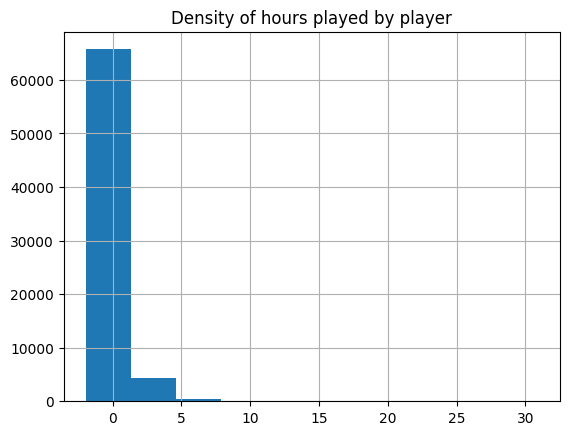

In [16]:
plt.figure()
played_games['hours_played'].hist()
plt.title('Density of hours played by player')

Text(0.5, 1.0, 'Density of games owned by player')

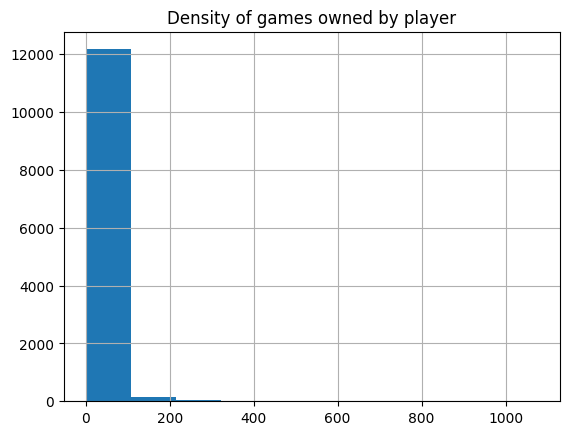

In [17]:
plt.figure()
bought_games.groupby(['id'])['game'].count().hist()
plt.title('Density of games owned by player')

It seems that the distribution is exponential, the majority of players only buy a few games, and play for a few hours. Let's check what happens for the outliers.

Text(0.5, 1.0, 'Density of hours played by outlier players')

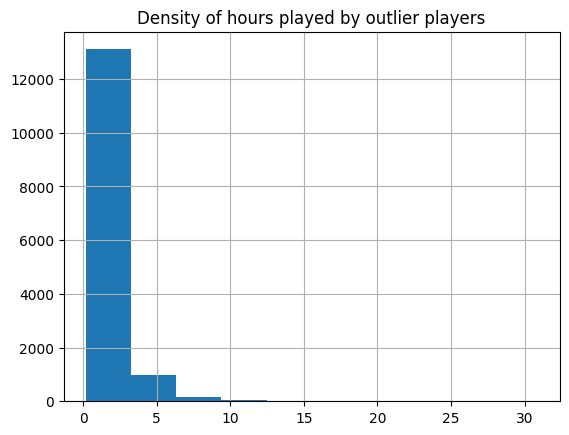

In [18]:
plt.figure()
played_games.loc[played_games['hours_played']>0.2,'hours_played'].hist()
plt.title('Density of hours played by outlier players')

Text(0.5, 1.0, 'Density of games owned by outlier players')

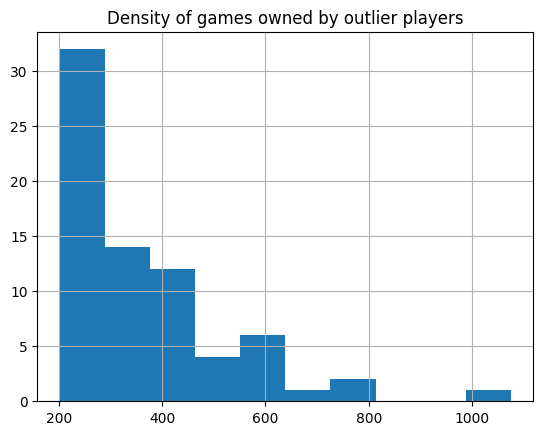

In [19]:
plt.figure()
bought_games.groupby(['id'])['game'].count().loc[bought_games.groupby(['id'])['game'].count()>200].hist()
plt.title('Density of games owned by outlier players')

Even for outliers, the exponential distribution seems to be verified.

# Technical ideas
## 1- Recommendations on games bought -> cluster players depending on the game they have bought
This problem, considering only the games that have been bought, is really similar to the problem of the market basket analysis, and we will thus try to use an apriori algorithm to solve it, which means deducing from the game bought by a person which other games people that buy those usually buy aswell.
## 2- Recommendations base on hours played
K-NN on players

# 2)
The aim of the algorithm is to predict a list of games someone may like knowing how much he played to other games.
It means that the feature we want to predict is a list of games, and the features used to do so are, for each game in the database, the amount of hours spent playing this game.

We then want X, Y like this :  
X = [0,0,...,0,5.2,0,10,...]  
Y = [0,1,1,0,0,1,...] (the one-encoded vector of the games liked) 

To determine the k neighbors, we will use the L2 distance on the vectors of hours played for each game.  
With this distance, firstly people that played a lot the same games will be near from each other, but it will also cluster types of players : those who play a lot of different games will be together, and the niche player will be separated.  

To make a prediction, we will compute using this distance the k neighbors of a player, and make a prediction.  
For this prediction, the k-nn algorithm usually choses the majority class of the neighbors. Thus, we could define a class as the one-hot-encoding of the games played by the user. However, this may lead to 1 class per neighbor, as it is highly possible that every player in the neighborhood, even if they are close one to each other, have tried a game the other ones never played to.  
That's why we choose as a result to give the union of all the games played by the neighbors. This will guarantee that the games resulting will be chosen because they are characteristical of the neighborhood.  
Obviously, we will remove from the result the games already played by the initial player (we don't want to recommand to someone a game he already played for 200 hours...)

In [20]:
played_games.head()

,id,game,hours_played
0,151603712,The Elder Scrolls V Skyrim,0.970886
2,151603712,Fallout 4,0.294820
4,151603712,Spore,-0.193861
6,151603712,Fallout New Vegas,-0.540694
8,151603712,Left 4 Dead 2,-0.223730


In [21]:
#Get a dict of games and hours played for each id
played_dict = played_games.groupby('id').apply(lambda g : dict(zip(g['game'], g['hours_played'])))
played_dict.head()

id
5250      {'Cities Skylines': 3.158903786773205, 'Deus E...
76767     {'Counter-Strike': 0.20796408562479032, 'Call ...
86540     {'The Elder Scrolls V Skyrim': 0.0478209339091...
144736              {'Counter-Strike': -0.3820160793060811}
181212    {'Counter-Strike': -0.3792674734404125, 'Half-...
dtype: object

In [22]:
#Create vectors of hours played 
hours_encoded = played_dict.apply(pd.Series)
#Replace NaN values by 0 : a game not in the dict has never been played
hours_encoded = hours_encoded.fillna(0)
#We drop the ids because they are not useful anymore
hours_encoded = hours_encoded.reset_index(drop=True)
#Sort by name of games
hours_encoded = hours_encoded.reindex(sorted(hours_encoded.columns),axis=1)
hours_encoded.head()

,007 Legends,0RBITALIS,1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),10 Second Ninja,"10,000,000",100% Orange Juice,1000 Amps,12 Labours of Hercules,12 Labours of Hercules II The Cretan Bull,12 Labours of Hercules III Girl Power,...,rFactor,rFactor 2,realMyst,realMyst Masterpiece Edition,resident evil 4 / biohazard 4,rymdkapsel,sZone-Online,the static speaks my name,theHunter,theHunter Primal
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
#Get the list of games
games_list = list(hours_encoded.columns)
games_list.sort()
len(games_list)

3600

In [24]:
#We now create our "classes" : the list of games played by each player
played_list = played_games.groupby('id')['game'].apply(list).reset_index(drop=True)
played_list.head()

0    [Cities Skylines, Deus Ex Human Revolution, Po...
1    [Counter-Strike, Call of Duty World at War, To...
2    [The Elder Scrolls V Skyrim, Audiosurf, XCOM E...
3                                     [Counter-Strike]
4             [Counter-Strike, Half-Life 2 Lost Coast]
Name: game, dtype: object

In [25]:
#And we one-hot encode them
from sklearn.preprocessing import MultiLabelBinarizer
#One-hot-encode the lists
mlb = MultiLabelBinarizer()

played_encoded = pd.DataFrame(mlb.fit_transform(played_list),
                   columns=mlb.classes_)

played_encoded.head()

,007 Legends,0RBITALIS,1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),10 Second Ninja,"10,000,000",100% Orange Juice,1000 Amps,12 Labours of Hercules,12 Labours of Hercules II The Cretan Bull,12 Labours of Hercules III Girl Power,...,rFactor,rFactor 2,realMyst,realMyst Masterpiece Edition,resident evil 4 / biohazard 4,rymdkapsel,sZone-Online,the static speaks my name,theHunter,theHunter Primal
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
#Create training and testing sets
#We just let the bought games in y values, but labels are not useful there because we will only compute the
#neighbors and find the result ourselves
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(hours_encoded, played_encoded, test_size=0.2, random_state=42)

Let's check if our data and labels are coherent

In [27]:
X_train.iloc[150]

007 Legends                                                   0.0
0RBITALIS                                                     0.0
1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby)    0.0
10 Second Ninja                                               0.0
10,000,000                                                    0.0
                                                             ... 
rymdkapsel                                                    0.0
sZone-Online                                                  0.0
the static speaks my name                                     0.0
theHunter                                                     0.0
theHunter Primal                                              0.0
Name: 10527, Length: 3600, dtype: float64

In [28]:
#To retrieve the list of played games, we get the list of games with a
#non zero time played and check the name corresponding to the index
def games_of_player(i):
    return [games_list[index] for index in list(np.asarray(y_train.iloc[i]).nonzero())[0]]

games_of_player(150)

["Assassin's Creed Revelations",
 'Borderlands',
 'Counter-Strike Global Offensive',
 'Darksiders',
 'Darksiders II',
 "Deus Ex Human Revolution - Director's Cut",
 'Fallout 3',
 'Fallout New Vegas',
 'Half-Life 2',
 'Hard Reset',
 'Hitman Codename 47',
 'Metro 2033',
 'ORION Prelude',
 'PROTOTYPE 2',
 'Remember Me']

In [29]:
X_train.iloc[150][['Counter-Strike Global Offensive','Fallout New Vegas','Borderlands']]

Counter-Strike Global Offensive    0.065582
Fallout New Vegas                 -0.378141
Borderlands                       -0.419914
Name: 10527, dtype: float64

It seems clean! Let's implement the knn algorithm

In [30]:
from sklearn.neighbors import NearestNeighbors

We will choose 100 neighbors. As we have almost 10000 users, it means we link a player to 1% of the dataset, which seems to be a fair choice.

In [31]:
neigh = NearestNeighbors(n_neighbors=100, metric='euclidean')
neigh.fit(X_train.values)

NearestNeighbors(metric='euclidean', n_neighbors=100)

In [32]:
kn = neigh.kneighbors([X_test.iloc[400]])

In [33]:
kn

(array([[0.67144898, 0.67145315, 0.67146982, 0.67206007, 0.67643122,
         0.71520583, 0.76151562, 0.77707296, 0.85966977, 0.85966977,
         0.88583856, 0.89441836, 0.9123968 , 0.9123968 , 0.91239682,
         0.91239682, 0.91239682, 0.91239682, 0.91239682, 0.91239686,
         0.91239686, 0.91239686, 0.91239686, 0.91239686, 0.91239686,
         0.91239686, 0.91239694, 0.91239694, 0.91239694, 0.91239694,
         0.91239694, 0.91239694, 0.91239694, 0.91239694, 0.91239705,
         0.91239705, 0.91239705, 0.91239705, 0.91239705, 0.91239705,
         0.91239718, 0.91239718, 0.91239718, 0.91239718, 0.91239718,
         0.91239718, 0.91239718, 0.91239718, 0.91239718, 0.91239718,
         0.91239718, 0.91239735, 0.91239735, 0.91239735, 0.91239735,
         0.91239735, 0.91239735, 0.91239735, 0.91239755, 0.91239755,
         0.91239755, 0.91239755, 0.91239755, 0.91239755, 0.91239755,
         0.91239755, 0.91239755, 0.91239755, 0.91239777, 0.91239777,
         0.91239777, 0.91239777, 0

In [34]:
games_of_player(5163)

['Dota 2']

In [35]:
X_test.iloc[400]['Dota 2']

-0.3215113027758875

In [36]:
X_train.iloc[5163]['Dota 2']

-0.3215113027758875

We notice that a lot of players have played the same popular games, and some of them have only played those ones.
In our example, the algorithm found a lot of neighbors that played the exact same time to Dota 2 than the initial player, and thus are chosen even thought they only played to Dota, which means we can't find a game to recommand.  
-> **outliers**  

Let's try to take only the players that played a minimum of 3 games.  

As we will have much less data, we will only take 5 neighbors.

In [37]:
played_dict_3 = played_dict.loc[played_dict.map(len)>=3]
played_dict_3.head()

id
5250      {'Cities Skylines': 3.158903786773205, 'Deus E...
76767     {'Counter-Strike': 0.20796408562479032, 'Call ...
86540     {'The Elder Scrolls V Skyrim': 0.0478209339091...
229911    {'Counter-Strike Condition Zero': 1.1203642472...
298950    {'Team Fortress 2': 3.045243405037884, 'Counte...
dtype: object

In [38]:
#Create vectors of hours played 
hours_encoded_3 = played_dict_3.apply(pd.Series)
#Replace NaN values by 0 : a game not in the dict has never been played
hours_encoded_3 = hours_encoded_3.fillna(0)
#We drop the ids because they are not useful anymore
hours_encoded_3 = hours_encoded_3.reset_index(drop=True)
#Sort by name of games
hours_encoded_3 = hours_encoded_3.reindex(sorted(hours_encoded_3.columns),axis=1)

#Get the list of games
games_list = list(hours_encoded_3.columns)
games_list.sort()

#We now create our "classes" : the list of games played by each player
played_list_3 = played_list.loc[played_list.map(len)>=3]

#And we one-hot encode them
mlb = MultiLabelBinarizer()

played_encoded_3 = pd.DataFrame(mlb.fit_transform(played_list_3),
                   columns=mlb.classes_)

X_train, X_test, y_train, y_test = train_test_split(hours_encoded_3, played_encoded_3, test_size=0.2, random_state=42)


#To retrieve the list of played games, we get the list of games with a
#non zero time played and check the name corresponding to the index
def games_of_player_train(i):
    return [games_list[index] for index in list(np.asarray(y_train.iloc[i]).nonzero())[0]]

def games_of_player_test(i):
    return [games_list[index] for index in list(np.asarray(y_test.iloc[i]).nonzero())[0]]

neigh = NearestNeighbors(n_neighbors=5, metric='euclidean')
neigh.fit(X_train.values)

NearestNeighbors(metric='euclidean')

In [39]:
games_of_player_test(30)

['Far Cry',
 'Far Cry 3',
 'Far Cry 3 Blood Dragon',
 'Grand Theft Auto V',
 'Team Fortress 2',
 'The Elder Scrolls V Skyrim']

In [40]:
kn = neigh.kneighbors([X_test.iloc[30]])
kn

(array([[0.79571713, 0.79902462, 0.80780405, 0.82446456, 0.8304481 ]]),
 array([[ 980, 2151, 1410, 2507, 1544]]))

In [41]:
games_of_player_train(1643)

['Loadout',
 'PlanetSide 2',
 'Team Fortress 2',
 'The Elder Scrolls V Skyrim',
 'Transformice']

In [42]:
games_of_player_train(2162)

['Fallen Earth', 'The Elder Scrolls V Skyrim', 'Warframe', 'theHunter']

The results seem pretty good : the neighbors have played games of the same genre as the initial player.  

However, if we do what we explained before : take the union of games played by the neighbors, we quickly realise that we will have a lot of games recommanded. Moreover, those recommandations may be irrelevant : if someone close played a game for only a few hours, it probably means that he didn't like it and thus we should not recommand it to the same type of player.  

That's why we will take the games **liked** by the neighbors. To do so, we will define a game as liked if a player has played more than the average time spent on the game by all the players of the dataset that have launched the game (not to take into account all the players that did not buy it).  

With our standardization, it means that we will take games with positive hours played.

In [43]:
played_dict_3 = played_dict.loc[played_dict.map(len)>=3]
played_dict_3.head()

id
5250      {'Cities Skylines': 3.158903786773205, 'Deus E...
76767     {'Counter-Strike': 0.20796408562479032, 'Call ...
86540     {'The Elder Scrolls V Skyrim': 0.0478209339091...
229911    {'Counter-Strike Condition Zero': 1.1203642472...
298950    {'Team Fortress 2': 3.045243405037884, 'Counte...
dtype: object

In [44]:
#Let's compute the liked games for each player


def dict_to_liked(dicti):
    d = dicti.copy()
    for game in d.keys():
        if d[game] > 0:
            d[game]=1
        else:
            d[game]=0
    return d

#For each player that played at least 3 games, we compute the list of game he like
liked_games = played_dict_3.map(dict_to_liked)
liked_games

id
5250         {'Cities Skylines': 1, 'Deus Ex Human Revoluti...
76767        {'Counter-Strike': 1, 'Call of Duty World at W...
86540        {'The Elder Scrolls V Skyrim': 1, 'Audiosurf':...
229911       {'Counter-Strike Condition Zero': 1, 'Call of ...
298950       {'Team Fortress 2': 1, 'Counter-Strike Global ...
                                   ...                        
306547522    {'Warface': 0, 'Dota 2': 0, 'Strife': 0, 'Team...
306971738    {'The Elder Scrolls IV Oblivion ': 0, 'Terrari...
308695132    {'La Tale': 0, 'Champions Online': 0, 'Brawlha...
308760273    {'Toribash': 0, 'Unturned': 0, 'Team Fortress ...
309404240    {'Unturned': 0, 'Team Fortress 2': 0, 'Mitos.i...
Length: 3466, dtype: object

In [45]:
#And encode them
liked_games_encoded = liked_games.apply(pd.Series)
#Replace NaN values by 0 : a game not in the dict has never been played
liked_games_encoded = liked_games_encoded.fillna(0)
liked_games_encoded = liked_games_encoded.reindex(sorted(liked_games_encoded.columns),axis=1)
liked_games_encoded

,007 Legends,0RBITALIS,1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),10 Second Ninja,"10,000,000",100% Orange Juice,1000 Amps,12 Labours of Hercules,12 Labours of Hercules II The Cretan Bull,12 Labours of Hercules III Girl Power,...,rFactor,rFactor 2,realMyst,realMyst Masterpiece Edition,resident evil 4 / biohazard 4,rymdkapsel,sZone-Online,the static speaks my name,theHunter,theHunter Primal
id,,,,,,,,,,,,,,,,,,,,,
5250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
229911,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
298950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306547522,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
306971738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
308695132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
hours_encoded_3 = played_dict_3.apply(pd.Series)
#Replace NaN values by 0 : a game not in the dict has never been played
hours_encoded_3 = hours_encoded_3.fillna(0)
hours_encoded_3 = hours_encoded_3.reindex(sorted(hours_encoded_3.columns),axis=1)

We can then rebuild our model using liked_games as our new classes, as that is exactly what we want to predict : what games the player could like

In [47]:
#Get the list of games
games_list = list(hours_encoded_3.columns)
games_list.sort()

X_train, X_test, y_train, y_test = train_test_split(hours_encoded_3, liked_games_encoded, test_size=0.2, random_state=42)


#To retrieve the list of played games, we get the list of games with a
#non zero time played and check the name corresponding to the index
def games_of_player_train(i):
    return [games_list[index] for index in list(np.asarray(X_train.iloc[i]).nonzero())[0]]

def games_of_player_test(i):
    return [games_list[index] for index in list(np.asarray(X_test.iloc[i]).nonzero())[0]]

neigh = NearestNeighbors(n_neighbors=5, metric='euclidean')
neigh.fit(X_train.values)

NearestNeighbors(metric='euclidean')

We can now create our recommendation function :  

Taking :  
- a player X, ie a vector of hours played for each game  
- a knn model fitted on values as shown before  
- the samples used for training

It returns :  
- the list of games liked by the k neighbors that X never played

In [48]:
def recommendations(X, model, samples):
    #Get the list of games played by X
    already_owned = [games_list[index] for index in np.asarray(X).nonzero()[0]]
    
    #Returns the union of games liked by neighbors 
    kneighbors = model.kneighbors([X])[1][0] #We get the indices of the neighbors
    
    recommandations = []
    for neighbor in kneighbors:
        recommandations = recommandations+[games_list[index] for index in np.asarray(samples.iloc[neighbor]).nonzero()[0]]
    
    #remove duplicates
    recommandations = list(dict.fromkeys(recommandations))
    
    #remove games already owned by X
    recommandations = [game for game in recommandations if game not in already_owned]
    
    return recommandations

In [49]:
games_of_player_test(250)

['Counter-Strike Global Offensive', 'Dota 2', 'PAYDAY The Heist']

In [50]:
recommendations(X_test.iloc[250], neigh, y_train)

['Far Cry 3',
 "Sid Meier's Civilization V",
 'Star Wars - Battlefront II',
 'Sniper Elite V2',
 'Unturned',
 'War Thunder']

In [51]:
#Let's create a test rpg player to test the recommendations
test_player = {'The Witcher 3 Wild Hunt':132,'The Elder Scrolls V Skyrim':224, 'Far Cry':90}

encoded_player = pd.Series(test_player,index=games_list).fillna(0)

In [52]:
recommendations(encoded_player, neigh, y_train)

['Anno 2070',
 "Assassin's Creed II",
 'BioShock',
 'Borderlands 2',
 'Call of Duty 4 Modern Warfare',
 'Call of Duty Black Ops',
 'Call of Duty Modern Warfare 2',
 'Call of Duty Modern Warfare 3',
 'Call of Duty World at War',
 'DC Universe Online',
 'Dungeons & Dragons Daggerdale',
 'Endless Space',
 'Fable III',
 'Fallout 4',
 'Grey Goo',
 'Homefront',
 'Medal of Honor(TM) Single Player',
 'Portal',
 'Shadowrun Returns',
 'Star Trek Online',
 'Sunless Sea',
 'Tomb Raider',
 'Toy Soldiers',
 'BRINK',
 'Call of Duty Ghosts',
 'Call of Juarez Gunslinger',
 'Fallout 3 - Game of the Year Edition',
 'Hitman Absolution',
 'Middle-earth Shadow of Mordor',
 'Resident Evil Revelations / Biohazard Revelations',
 'Risen 2 - Dark Waters',
 'Stronghold 3',
 'Thief',
 'Wolfenstein The New Order German Edition',
 'ArcaniA',
 'Half-Life 2 Episode One',
 'The Darkness II',
 'A Game of Thrones - Genesis',
 'Age of Mythology Extended Edition',
 'Banished',
 'DUNGEONS - Steam Special Edition',
 'Dungeon

We get results that seem coherent (for this example we have same genre like rpgs, also series of games already played), but there are too much of them.  

To prevent this, we will firstly give a score to each result to determine the priority of recommendations, and then define how much maximum results we want.  

**Score**  
The score of a predicted game will be equal to the sum of the inverse distances to each neighbor, weighted by how much the neighbors liked the game (the difference between the hours played and the mean).  
With this score, the more a game has been played by people who like the same games and the more it has been liked by them, the more it will have chances to be predicted.  

To do so, we set to 0 the negative values of hours, meaning that we only keep games likes and the value will be proportional to the difference to the average.

In [53]:
def dict_to_likeness(dicti):
    d = dicti.copy()
    for game in d.keys():
        if d[game] < 0:
            d[game]= 0
    return d

#For each player that played at least 3 games, we compute the list of game he like
likeness_games = played_dict_3.map(dict_to_likeness)
likeness_games

id
5250         {'Cities Skylines': 3.158903786773205, 'Deus E...
76767        {'Counter-Strike': 0.20796408562479032, 'Call ...
86540        {'The Elder Scrolls V Skyrim': 0.0478209339091...
229911       {'Counter-Strike Condition Zero': 1.1203642472...
298950       {'Team Fortress 2': 3.045243405037884, 'Counte...
                                   ...                        
306547522    {'Warface': 0, 'Dota 2': 0, 'Strife': 0, 'Team...
306971738    {'The Elder Scrolls IV Oblivion ': 0, 'Terrari...
308695132    {'La Tale': 0, 'Champions Online': 0, 'Brawlha...
308760273    {'Toribash': 0, 'Unturned': 0, 'Team Fortress ...
309404240    {'Unturned': 0, 'Team Fortress 2': 0, 'Mitos.i...
Length: 3466, dtype: object

The new recommendation function will then return a vector of probabilities that the player may like each game.

In [54]:
#And encode them
likeness_games_encoded = likeness_games.apply(pd.Series)
#Replace NaN values by 0 : a game not in the dict has never been played
likeness_games_encoded = likeness_games_encoded.fillna(0)
likeness_games_encoded = likeness_games_encoded.reindex(sorted(likeness_games_encoded.columns),axis=1)

In [55]:
#We define a custom train test split function to shuffle the likeness with the two other dataframes
def train_test_split_likeness(hours, liked_games, likeness, test_size=0.2):
    
    #shuffle
    indexes = np.asarray(hours.index).copy()
    np.random.seed(42) #set seed for reproducability
    np.random.shuffle(indexes)
    hours_shuffled = hours.loc[indexes]
    liked_games_shuffled = liked_games.loc[indexes]
    likeness_shuffled = likeness.loc[indexes]
    
    #split train and test
    separator = len(hours) - int(len(hours)* test_size)
    X_train = hours_shuffled.iloc[:separator]
    y_train = liked_games_shuffled.iloc[:separator]
    X_test = hours_shuffled.iloc[separator:]
    y_test = liked_games_shuffled.iloc[separator:]
    
    return X_train,X_test,y_train,y_test,likeness_shuffled

In [56]:
X_train, X_test, y_train, y_test, likeness = train_test_split_likeness(hours_encoded_3, liked_games_encoded, likeness_games_encoded, test_size=0.2)


#To retrieve the list of played games, we get the list of games with a
#non zero time played and check the name corresponding to the index
def games_of_player_train(i):
    return [games_list[index] for index in list(np.asarray(X_train.iloc[i]).nonzero())[0]]

def games_of_player_test(i):
    return [games_list[index] for index in list(np.asarray(X_test.iloc[i]).nonzero())[0]]

neigh = NearestNeighbors(n_neighbors=5, metric='euclidean')
neigh.fit(X_train.values)

NearestNeighbors(metric='euclidean')

In [57]:
def score(X, model, likeness):
    #Create a vector with all games and a null score
    score = pd.Series({games_list[0]:0.0},index=games_list).fillna(0)
    
    #Get the list of games played by X
    already_owned = [games_list[index] for index in np.asarray(X).nonzero()[0]]
    
    #Get the neighbors of X
    kneighbors = model.kneighbors([X])
    kneighbors_distances = kneighbors[0][0]
    kneighbors_indices = kneighbors[1][0]
    
    for i in range(len(kneighbors_indices)):
        neighbor = kneighbors_indices[i]
        #get the list of liked games
        liked = [games_list[index] for index in np.asarray(likeness.iloc[neighbor]).nonzero()[0]]
        #Add to each game score (1/d)*l with d the distance between X and the neighbor
        #and l the amount of time played above the average
        for liked_game in liked:
            if liked_game not in already_owned:
                score[liked_game] = score[liked_game] + 1/kneighbors_distances[i] + likeness.iloc[neighbor][liked_game]
            
    
    return score.sort_values(ascending=False)

In [58]:
dict(score(encoded_player, neigh, likeness))

{'Medal of Honor(TM) Single Player': 5.167203361811293,
 "Tom Clancy's Splinter Cell Blacklist": 3.8767318856965547,
 'Rome Total War': 3.8553351998618384,
 'Middle-earth Shadow of Mordor': 3.3553337597994486,
 'A Game of Thrones - Genesis': 3.199345188988867,
 'Star Wars Empire at War Gold': 3.0703757349142924,
 'Call of Duty 4 Modern Warfare': 2.8868990897913793,
 'Stronghold 3': 2.8334860199370677,
 'Fallout 3 - Game of the Year Edition': 2.6444250227878716,
 'Mafia II': 2.6437238618602263,
 'S.T.A.L.K.E.R. Call of Pripyat': 2.617017972398454,
 'Sunless Sea': 2.5793778491182215,
 'Thief': 2.39538664157769,
 'Hitman Absolution': 2.3017264957209607,
 'Deus Ex Human Revolution': 2.2377269594122953,
 'Toy Soldiers': 2.2141294323955196,
 "Tom Clancy's Splinter Cell": 2.2118791275287832,
 'Dead Space 2': 2.2034767543082423,
 'Endless Space': 2.0099696270999594,
 'Patrician IV Steam Special Edition': 1.974416453577219,
 'Dungeons & Dragons Daggerdale': 1.8213465374510696,
 'Tomb Raider': 1

With this score, the results are much more satisfying !

Now that our method is set, let's create a model class to clean everything

In [59]:
class SteamPredictionModel():
    
    def __init__(self, k_neighbors = 5):
        self.neigh = NearestNeighbors(n_neighbors=k_neighbors, metric='euclidean')
        self.games_list = []
        self.avg_dict = {}
        self.likeness = None
        
    def dict_to_likeness(self,dicti):
        d = dicti.copy()
        for game in d.keys():
            if d[game] < 0:
                d[game]= 0
        return d
    
    #We fit the model on a dataset containing ids and dictionnaries of games associated with time played
    def fit(self, data):
        hours_encoded = data.apply(pd.Series)
        #Replace NaN values by 0 : a game not in the dict has never been played
        hours_encoded = hours_encoded.fillna(0)
        hours_encoded = hours_encoded.reindex(sorted(hours_encoded.columns),axis=1)
        
        self.neigh.fit(hours_encoded.values)
        
        #Get the list of games
        games_list = list(hours_encoded.columns)
        games_list.sort()
        self.games_list = games_list
        
        #For each player, we compute the list of game he likes with the time he has played aboved average time played
        likeness_games = data.map(self.dict_to_likeness)
        #And encode them
        likeness_games_encoded = likeness_games.apply(pd.Series)
        #Replace NaN values by 0 : a game not in the dict has never been played
        likeness_games_encoded = likeness_games_encoded.fillna(0)
        likeness_games_encoded = likeness_games_encoded.reindex(sorted(likeness_games_encoded.columns),axis=1)
        self.likeness = likeness_games_encoded
    
    #We predict a certain number of games (maximum) using a dictionnary of games associated with time played
    def predict(self, X_init, recommendations_number_max):
        #One-hot-encode X
        X = score = pd.Series(X_init,index=self.games_list).fillna(0)
        
        #Create a vector with all games and a null score
        score = pd.Series({self.games_list[0]:0.0},index=self.games_list).fillna(0)

        #Get the list of games played by X
        already_owned = [self.games_list[index] for index in np.asarray(X).nonzero()[0]]

        #Get the neighbors of X
        kneighbors = self.neigh.kneighbors([X])
        kneighbors_distances = kneighbors[0][0]
        kneighbors_indices = kneighbors[1][0]

        for i in range(len(kneighbors_indices)):
            neighbor = kneighbors_indices[i]
            #get the list of liked games
            liked = [self.games_list[index] for index in np.asarray(self.likeness.iloc[neighbor]).nonzero()[0]]
            #Add to each game score (1/d)*l with d the distance between X and the neighbor
            #and l the amount of time played above the average
            for liked_game in liked:
                if liked_game not in already_owned:
                    score[liked_game] = score[liked_game] + 1/kneighbors_distances[i] + self.likeness.iloc[neighbor][liked_game]


        score = score.sort_values(ascending=False)
        return score.iloc[:recommendations_number_max]

In [60]:
SPM = SteamPredictionModel(5)
SPM.fit(played_dict_3)

In [61]:
SPM.predict(test_player,10)

Medal of Honor(TM) Single Player        5.167203
Tom Clancy's Splinter Cell Blacklist    3.876732
Rome Total War                          3.855335
Middle-earth Shadow of Mordor           3.355334
A Game of Thrones - Genesis             3.199345
Star Wars Empire at War Gold            3.070376
Call of Duty 4 Modern Warfare           2.886899
Stronghold 3                            2.833486
Fallout 3 - Game of the Year Edition    2.644425
Mafia II                                2.643724
dtype: float64

## Knn evaluation

The evaluation metrics we have seen in class are fitted to classifiers evaluation. 
To use them, we will evaluate our algorithm using the testing set like this:  
- 1. remove 5% of the games from the player's played games (the most played)
- 2. use the algorithm to predict the number of games lacking
- 3. compare the recommendation to the games that have been removed in step 1  

The result of the evaluation is: 
- true positive if the game predicted was in the games removed
- false positive if the game predicted was not in the games removed

The number of false negatives (not to predict a game that has been removed) is then exactly equals to the number of false positives, and the number of true negatives is irrelevant here.

That's why we will use the **precision** metrics to evaluate our model.

First, let's split our data into random training and testing sets

In [62]:
def train_test_split(data, test_size=0.2):
    
    #shuffle
    shuffled = data.sample(frac=1, random_state=42) #set seed for reproducability
    
    #split train and test
    separator = len(shuffled) - int(len(shuffled)* test_size)
    X_train = shuffled.iloc[:separator]
    X_test = shuffled.iloc[separator:]
    
    return X_train,X_test

X_train, X_test = train_test_split(played_dict_3)

In [63]:
#Create and fit the model
SPM = SteamPredictionModel(5)
SPM.fit(X_train)

In [64]:
from tqdm import tqdm

#Evaluate the model
true_positives = 0
false_positives = 0

for player in tqdm(X_test):
    
    player_games = len(player)
    
    games_to_predict = int(len(player)*5/100)
    if games_to_predict == 0:
        games_to_predict = 1 #we remove at least one game
        
    games_for_prediction = dict(list(player.items())[games_to_predict:])
    games_removed = list(player.keys())[:games_to_predict]
    
    prediction = list(SPM.predict(games_for_prediction,games_to_predict).index)
    
    for predicted_game in prediction:
        if predicted_game in games_removed:
            true_positives += 1
        else:
            false_positives += 1

precision = true_positives/(true_positives+false_positives)

ModuleNotFoundError: No module named 'tqdm'

In [ ]:
true_positives, false_positives, precision

(49, 855, 0.05420353982300885)

The result is obviously extremely underwhelming. Indeed, given a random game, it is highly probable that a random person would not like it, and thus gives this result. Moreover, the model tends to work better for people that have played a lot of games, and as we're using data from people that may have played only 3 games, predicting 33% of all the games played by someone is really hard.

Let's try different values of the number of neighbors.

In [ ]:
precisions = []
for n in tqdm(range(1,21)):
    #Create and fit the model
    SPM = SteamPredictionModel(n)
    SPM.fit(X_train)
    
    true_positives = 0
    false_positives = 0

    for player in X_test:

        player_games = len(player)

        games_to_predict = int(len(player)*5/100)
        if games_to_predict == 0:
            games_to_predict = 1 #we remove at least one game

        games_for_prediction = dict(list(player.items())[games_to_predict:])
        games_removed = list(player.keys())[:games_to_predict]

        prediction = list(SPM.predict(games_for_prediction,games_to_predict).index)

        for predicted_game in prediction:
            if predicted_game in games_removed:
                true_positives += 1
            else:
                false_positives += 1

    precisions.append(true_positives/(true_positives+false_positives))

100%|███████████████████████████████████████████| 20/20 [08:40<00:00, 26.00s/it]


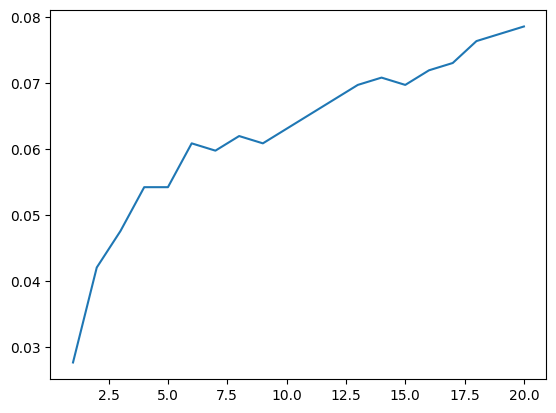

In [ ]:
plt.plot(range(1,21),precisions)

# Frequent itemset implementation

We want to see how well we can recommend games using frequent itemset

In [66]:
grouped = played_games.drop('hours_played', axis=1)
grouped = grouped.groupby('id')['game'].apply(list).reset_index(name='games')
grouped['games']



0        [Cities Skylines, Deus Ex Human Revolution, Po...
1        [Counter-Strike, Call of Duty World at War, To...
2        [The Elder Scrolls V Skyrim, Audiosurf, XCOM E...
3                                         [Counter-Strike]
4                 [Counter-Strike, Half-Life 2 Lost Coast]
                               ...                        
11345                                             [Dota 2]
11346                                  [Mitos.is The Game]
11347                       [Age of Empires II HD Edition]
11348                                             [Dota 2]
11349                                             [Dota 2]
Name: games, Length: 11350, dtype: object

In [67]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
te = TransactionEncoder()
te_ary = te.fit(grouped['games']).transform(grouped['games'])
df = pd.DataFrame(te_ary, columns=te.columns_)
df
fis = apriori(df, min_support=0.02, use_colnames=True)
fis


,support,itemsets
0,0.025463,(Alien Swarm)
1,0.034009,(Borderlands 2)
2,0.020000,(Call of Duty Black Ops)
3,0.026167,(Call of Duty Modern Warfare 2)
4,0.025639,(Call of Duty Modern Warfare 2 - Multiplayer)
...,...,...
68,0.022907,"(Unturned, Counter-Strike Global Offensive, Te..."
69,0.021145,"(Garry's Mod, Dota 2, Team Fortress 2)"
70,0.023172,"(Dota 2, Team Fortress 2, Left 4 Dead 2)"
71,0.022555,"(Dota 2, Unturned, Team Fortress 2)"


In [75]:
ar = association_rules(fis, metric="confidence", min_threshold=0.5)
ar

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Borderlands 2),(Team Fortress 2),0.034009,0.204670,0.020969,0.616580,3.012564,0.014009,2.074308
1,(Call of Duty Modern Warfare 2 - Multiplayer),(Call of Duty Modern Warfare 2),0.025639,0.026167,0.022731,0.886598,33.881773,0.022060,8.587433
2,(Call of Duty Modern Warfare 2),(Call of Duty Modern Warfare 2 - Multiplayer),0.026167,0.025639,0.022731,0.868687,33.881773,0.022060,7.420136
3,(Garry's Mod),(Counter-Strike Global Offensive),0.058678,0.121322,0.033304,0.567568,4.678208,0.026185,2.031944
4,(PAYDAY 2),(Counter-Strike Global Offensive),0.034361,0.121322,0.023877,0.694872,5.727520,0.019708,2.879702
5,(Terraria),(Counter-Strike Global Offensive),0.040529,0.121322,0.020881,0.515217,4.246708,0.015964,1.812520
6,(Warframe),(Dota 2),0.037357,0.426520,0.020264,0.542453,1.271812,0.004331,1.253379
7,(Garry's Mod),(Team Fortress 2),0.058678,0.204670,0.040088,0.683183,3.337981,0.028078,2.510379
8,(Portal 2),(Left 4 Dead 2),0.039912,0.070573,0.020352,0.509934,7.225653,0.017536,1.896534
9,(Left 4 Dead 2),(Team Fortress 2),0.070573,0.204670,0.040264,0.570537,2.787599,0.025820,1.851918


In [83]:
def recommendation_ar(librairy):
    item_set_tmp = frozenset()
    for i in range(ar.shape[0]):
        if( set(ar.iloc[i][0]).issubset(set(librairy)) ):
            print(ar.iloc[i][0])
            item_set_tmp = frozenset.union(item_set_tmp,ar.iloc[i][1])
    item_set = list(item_set_tmp)
    return item_set
    

In [84]:
librairy = grouped.iloc[0][1]
print(librairy)
print(recommendation_ar(librairy))

['Cities Skylines', 'Deus Ex Human Revolution', 'Portal 2', 'Alien Swarm', 'Team Fortress 2', 'Dota 2']
frozenset({'Portal 2'})
frozenset({'Portal 2'})
frozenset({'Dota 2', 'Team Fortress 2'})
['Counter-Strike Global Offensive', 'Team Fortress 2', 'Left 4 Dead 2']


On peut remarquer que pour des supports allant de 10% à 5% on obtient presque uniquement les jeux les plus joués. Ce qui n'est pas étonnant comme on n'a pas filtré selon les temps de jeux. Obtenir une recommendation par association semble donc être futile.
On va voir s'il est possible de faire .
On va déjà faire rentrer le temps de jeu en paramètre : Si un joueur n'a pas plus d'heure de jeu que la moyenne pour un certain jeu, on ne le prend pas en compte.

In [69]:
avg = played_games.groupby('game')['hours_played'].apply(np.average).reset_index(name='avg_hours_played')
avg

,game,avg_hours_played
0,007 Legends,0.000000e+00
1,0RBITALIS,1.480297e-16
2,1... 2... 3... KICK IT! (Drop That Beat Like a...,-4.440892e-17
3,10 Second Ninja,0.000000e+00
4,"10,000,000",0.000000e+00
...,...,...
3595,rymdkapsel,0.000000e+00
3596,sZone-Online,1.215503e-16
3597,the static speaks my name,0.000000e+00
3598,theHunter,-3.715666e-17


In [70]:
#Dictionnary of average time played
avg_dict = avg.set_index('game').to_dict()['avg_hours_played']
avg_dict

{'007 Legends': 0.0,
 '0RBITALIS': 1.4802973661668753e-16,
 '1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby)': -4.4408920985006264e-17,
 '10 Second Ninja': 0.0,
 '10,000,000': 0.0,
 '100% Orange Juice': -9.251858538542972e-17,
 '1000 Amps': 0.0,
 '12 Labours of Hercules': 2.5376526277146434e-16,
 '12 Labours of Hercules II The Cretan Bull': 2.7755575615628914e-17,
 '12 Labours of Hercules III Girl Power': -1.4802973661668753e-16,
 '140': -3.3306690738754695e-17,
 '15 Days': 0.0,
 '16bit Trader': 0.0,
 '1701 A.D. Sunken Dragon': 0.0,
 '18 Wheels of Steel American Long Haul': 0.0,
 '1953 NATO vs Warsaw Pact': 0.0,
 '1Quest': 0.0,
 '3 Stars of Destiny': 0.0,
 '3089 -- Futuristic Action RPG': 0.0,
 '3D Mini Golf': 0.0,
 '3DMark': 4.0091387000352874e-17,
 '3DMark 11': 0.0,
 '3DMark Vantage': 0.0,
 '4 Elements': -5.551115123125783e-17,
 '404Sight': 3.172065784643304e-17,
 '500 Years Act 1': 0.0,
 '60 Seconds!': -1.3322676295501878e-16,
 '7 Days to Die': 7.901842445673946e-17,
 '8B

In [71]:
#To get the avg time played for a game
avg_dict['Dota 2']

3.1556845318822877e-17

In [72]:
#Select only the rows where players played more than average
played_games_sup_avg = played_games.loc[played_games['hours_played'] > played_games['game'].astype(str).map(avg_dict)]
played_games_sup_avg

,id,game,hours_played
0,151603712,The Elder Scrolls V Skyrim,0.970886
2,151603712,Fallout 4,0.294820
14,151603712,Poly Bridge,0.530591
68,59945701,Ultra Street Fighter IV,2.074111
70,59945701,FINAL FANTASY XIII,2.572824
...,...,...,...
199972,128470551,Arma 2 DayZ Mod,3.282974
199974,128470551,Antichamber,4.302705
199976,128470551,Risk of Rain,0.262915
199978,128470551,OlliOlli,0.707107


In [73]:
g = played_games_sup_avg.groupby('id')['game'].apply(list).reset_index(name='games')
g['games']
te_ary = te.fit(g['games']).transform(g['games'])
df2 = pd.DataFrame(te_ary, columns=te.columns_)
df2
fis2 = apriori(df2, min_support=0.001, use_colnames=True)
fis2.sort_values(by=['support'], ascending=False)

,support,itemsets
198,0.202215,(Dota 2)
128,0.093330,(Counter-Strike Global Offensive)
614,0.081075,(Team Fortress 2)
703,0.059628,(Unturned)
628,0.049022,(The Elder Scrolls V Skyrim)
...,...,...
859,0.001178,"(Magicka, Antichamber)"
2239,0.001178,"(Half-Life 2 Episode One, The Elder Scrolls V ..."
860,0.001178,"(Antichamber, Portal 2)"
861,0.001178,"(Antichamber, Terraria)"


In [ ]:
association_rules(fis2, metric="confidence", min_threshold=0.3)
ar.sort_values(by=['antecedent support'], ascending=False)